In [8]:
from big_helper import *
import matplotlib.pyplot as plt

name = 'baby'
num = 36
size = (28,28)

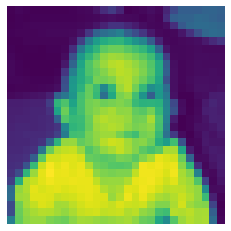

In [9]:
imgs = get_images(name, num, size) 
if name == 'TEXCOL':
    imgs = [img[0] for img in imgs] # 0 img, 1 colour mask, 2 texture mask


plot_images(imgs)

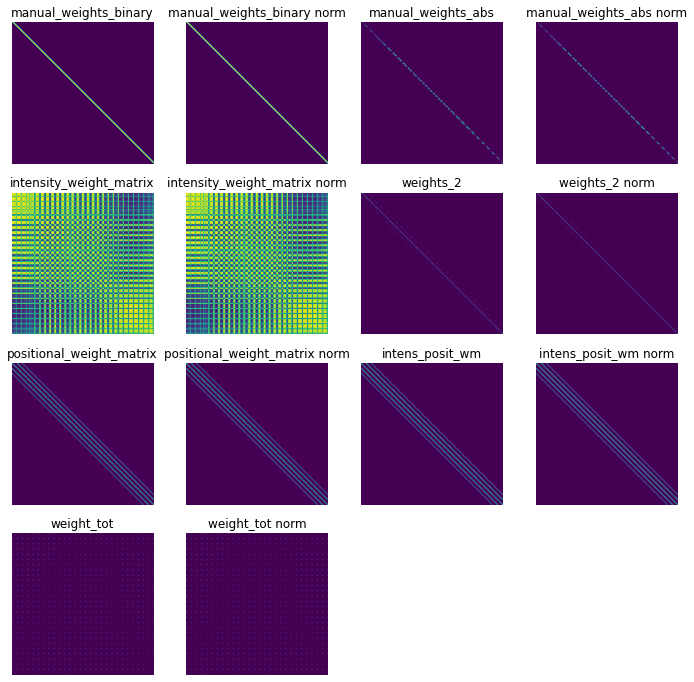

In [10]:
plt.rcParams["figure.figsize"] = (12,12) # specify the size for this cell


choices = ["manual_weights_binary", "manual_weights_abs", "intensity_weight_matrix", "weights_2", 
           "positional_weight_matrix", "intens_posit_wm", "weight_tot", "weight_int", "weight_dist"]

labels = []
if len(imgs) == 1:
    weights = []
    for i in range(7):
        labels.append(choices[i])
        weights.append(get_weights(imgs[0], i))
        labels.append(choices[i] + ' norm')
        weights.append(weights[-1]/np.max(weights[-1])) # normed version too
else:
    weights = [get_weights(img, 1) for img in imgs]
plot_images(weights, labels=labels)

# TODO: plot single rows to see the outputs of that (reshaped to 28x28 image)

In [11]:
# different valid image sets
# (real images too?)

# different weighting functions
# intens, position, affinity, intens * position...

# plot specific rows of the weights matrix (e.g. for intensity should show similar things in image)

# different weightings with W/np.max(W) (e.g. do we normalize the weights before doing laplace?)

# different laplace solvers
# cheap, expensive, symmetric/none...
# how to handle 0's in D? or... how to handle 0's in d?

# different eigensolvers
# initially try for just one eig solver?
# Time the eigensolvers

# linalg.eig(L)
# np.eig(L)

# linalg.eigh(L)
# linalg.eig(L)
# linalg.eigh(L,D)
# linalg.eig(L,D)
# plus the gvd variants etc....

# lobpcg (specifically setup for finding small eigenvalues unlike most other methods :) )

# outputs
# and with... * 28, * eigval, * np.sqrt(D)
# sign of outputs to make it an indicator vector
# objective, eqconst

# plot the eigenvalues for a different method... (see if > 0)
# plot the eigenvectors for different inputs
# plot ncut cost, at different partitions of the eigenvector range
# ^ and do this for the first so many eigenvectors :)

# also other plots probably mentioned in eigs-test2 or nc-test2/nc-test3... etc